In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from lens import profile
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift

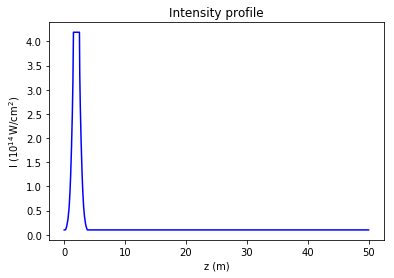

0.1001001001


In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.intensity_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

plt.plot(z/1e6, I, 'b-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.show()
print(I[N-1])

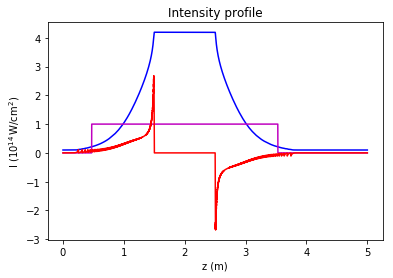

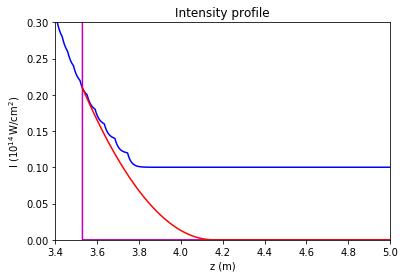

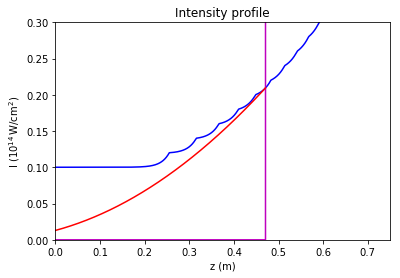

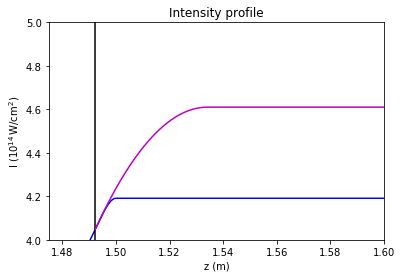

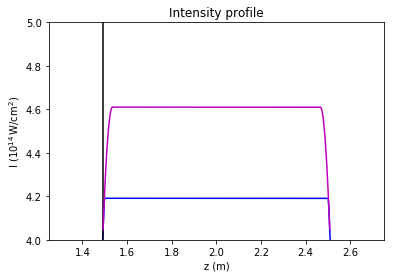

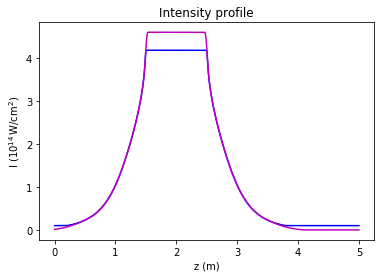

In [3]:
# To avoid significant ringing at the discontinuities we need the spectrum <0.1%

zf = 5e6
z, I = profile.intensity_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

# First we need to fix the baseline
Imax = np.amax(I)
smallI = np.zeros(N)
smallI[I > Imax*0.05] = 1.0
deltaZ = (zf-1)/N
grad = np.gradient(I, deltaZ)

plt.plot(z/1e6, I, 'b-', z/1e6, smallI, 'm-', z/1e6, grad*0.1e6, 'r-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.show()

smallInd = np.nonzero(smallI)
bot = np.amin(smallInd)
top = np.amax(smallInd)
topI1 = I[top]
topz1 = z[top]
topzp = grad[top]
topA = topzp**2/(4*topI1)
topB = topz1 - 2*topI1/topzp
topPar = topA*(z[top:]-topB)**2
sel = z[top:] > topB
topPar[sel] = 0.0

plt.plot(z/1e6, I, 'b-', z/1e6, smallI, 'm-', z[top:]/1e6, topPar, 'r-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.xlim([3.4,zf/1e6])
plt.ylim([0, 0.3])
plt.show()

botI1 = I[bot]
botz1 = z[bot]
botzp = grad[bot]
botA = botzp**2/(4*botI1)
botB = botz1 - 2*botI1/botzp
botPar = botA*(z[:bot]-botB)**2
sel = z[:bot] < botB
botPar[sel] = 0.0

plt.plot(z/1e6, I, 'b-', z/1e6, smallI, 'm-', z[:bot]/1e6, botPar, 'r-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.xlim([0,0.75])
plt.ylim([0, 0.3])
plt.show()

# Now fix the corners on the top
# index of peak gradient
indmax = np.argmax(grad)
indmin = np.argmin(grad)
c = np.amax(I) * 1.1
center = np.zeros(indmin-indmax)+c
zstart = z[indmax]
zend = z[indmin]
gradmax = grad[indmax]
gradmin = grad[indmin]
Iin = I[indmax]
Iout = I[indmin]
inA = gradmax**2/(4*(Iin-c))
outA = gradmin**2/(4*(Iout-c))
inB = zstart-2*(Iin-c)/gradmax
outB = zend-2*(Iout-c)/gradmin

sel = z[indmax:indmin] < inB
center[sel] = inA*(z[indmax:indmin][sel]-inB)**2+c
sel = z[indmax:indmin] > outB
center[sel] = outA*(z[indmax:indmin][sel]-outB)**2+c

plt.plot(z/1e6, I, 'b-',[zstart/1e6, zstart/1e6],[0,5],'k-', z[indmax:indmin]/1e6, center, 'm-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.xlim([1.475,1.6])
plt.ylim([4, 5])
plt.show()

plt.plot(z/1e6, I, 'b-',[zstart/1e6, zstart/1e6],[0,5],'k-', z[indmax:indmin]/1e6, center, 'm-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.xlim([1.25,2.75])
plt.ylim([4, 5])
plt.show()

# Finally put it all together
Ismooth = np.copy(I)
Ismooth[top:] = topPar
Ismooth[:bot] = botPar
Ismooth[indmax:indmin] = center

plt.plot(z/1e6, I, 'b-', z/1e6, Ismooth, 'm-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.show()

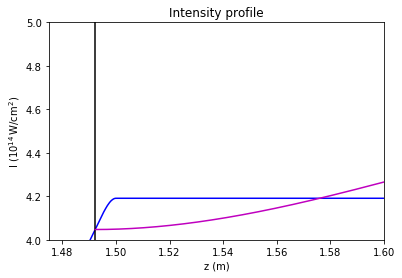

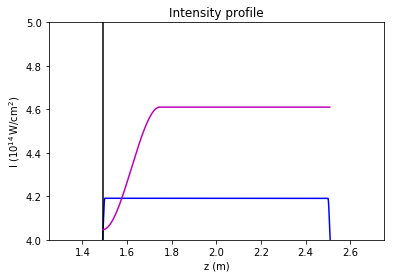

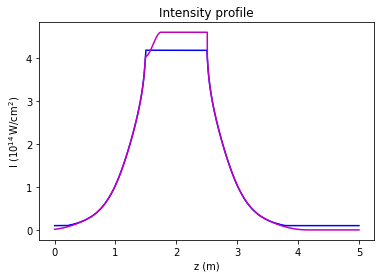

In [7]:
# Now fix the corners on the top
# index of peak gradient
indmax = np.argmax(grad)
indmin = np.argmin(grad)
Imax = np.amax(I) * 1.1
center = np.zeros(indmin-indmax)+Imax
zstart = z[indmax]
zend = z[indmin]
gradmax = grad[indmax]
gradmin = grad[indmin]
Iin = I[indmax]
Iout = I[indmin]
W = zend - zstart
z0 = zstart + W/4
a = Iin
b = gradmax
c = 3*(Imax-Iin) - 2*gradmax
d = 2*(Iin-Imax) + gradmax
t = (z - zstart)/(z0 - zstart)
sel = z[indmax:indmin] < z0
t = t[indmax:indmin][sel]
center[sel] = a + b*t + c*t**2 + d*t**3



#sel = z[indmax:indmin] > outB
#center[sel] = outA*(z[indmax:indmin][sel]-outB)**2+c

plt.plot(z/1e6, I, 'b-',[zstart/1e6, zstart/1e6],[0,5],'k-', z[indmax:indmin]/1e6, center, 'm-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.xlim([1.475,1.6])
plt.ylim([4, 5])
plt.show()

plt.plot(z/1e6, I, 'b-',[zstart/1e6, zstart/1e6],[0,5],'k-', z[indmax:indmin]/1e6, center, 'm-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.xlim([1.25,2.75])
plt.ylim([4, 5])
plt.show()

# Finally put it all together
Ismooth = np.copy(I)
Ismooth[top:] = topPar
Ismooth[:bot] = botPar
Ismooth[indmax:indmin] = center

plt.plot(z/1e6, I, 'b-', z/1e6, Ismooth, 'm-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.show()